# Bag of Visual Words Image Classification: Week 2
## Team 7: 
- Marcelo Sanchez Ortega
- Manel Guzmán Castellana 
- Jiaqiang Ye Zhu
- Sergi Vidal Bazan

In [1]:
%pip install opencv-contrib-python==3.4.2.17
%pip install scikit-image
%pip install pandas
%pip install requests
%pip install seaborn
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [21]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn import svm
import pandas as pd

---

***DATASET INTRODUCTION***

---

Let us first read the train and test files

In [5]:
train_images_filenames = pickle.load(open('../train_images_filenames.dat','rb'))  
test_images_filenames = pickle.load(open('../test_images_filenames.dat','rb'))
train_images_filenames = ["../" + n[16:] for n in train_images_filenames]   #a list of train image paths
test_images_filenames  = [ "../" + n[16:] for n in test_images_filenames]    #a list of test image paths
train_labels = pickle.load(open('../train_labels.dat','rb'))  #a list of class names
test_labels = pickle.load(open('../test_labels.dat','rb'))

Get one sample as example

In [6]:
sample = train_images_filenames[12]
img_sample = cv2.imread(sample)
img_sample_gray = cv2.cvtColor(img_sample,cv2.COLOR_BGR2GRAY)
img_sample_color = cv2.cvtColor(img_sample,cv2.COLOR_BGR2RGB)

Let's see how the images of each class look like

In [7]:
def plot_dataset(image_filenames, labels):
    """
    Show some images of the dataset
    """
    samples = 5
    print('Number of images:', len(image_filenames))
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(15,5))
    
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(np.array(labels) == cls)
        idxs = idxs[:5]
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()


Number of images: 1881


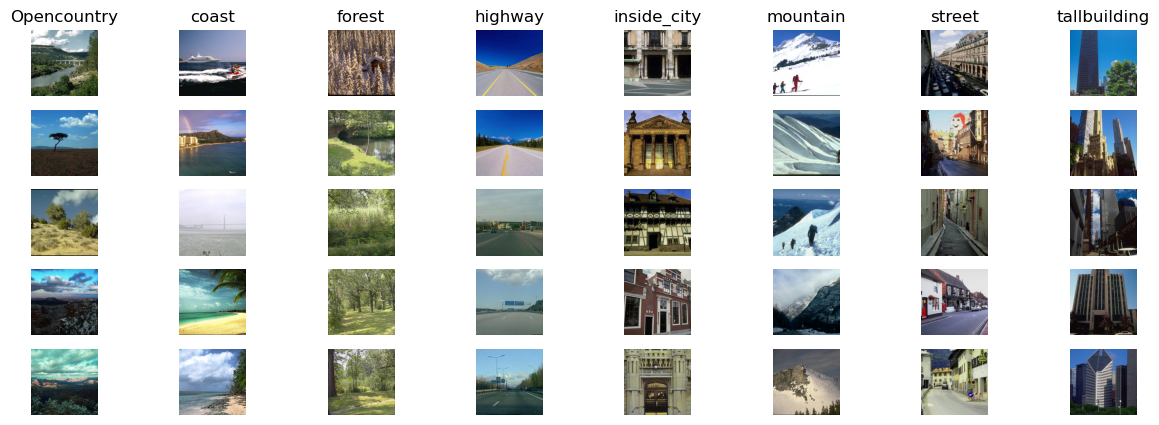

In [8]:
#for the training dataset
plot_dataset(train_images_filenames, train_labels)

In [9]:
def draw_keypoints(img, descriptor=None, kps=None):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp = descriptor.detect(gray)
    else:
        kp = kps

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Image','Keypoints:' + str(len(kp))]
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

---

***Project Recapt***

---

From the previouse weeks we can recapt:

- The local point  descriptors like SIFT and SURF overperfomance those binary techniques like KAZE or ORB in our classificaiton task

- The accuracy increases when we increase the amount of feature for SIFT and SURF descriptors

- DENSE SIFT is able to overperform vanilla SIFT due to its aavility to focus on those part that the vanilla SIFT does not take into account. Normally, it also increases computational time as log as increases the number of points.

In this week the algorithm used to create dense keypoints has been adapted to study the important of the scale of the keypoints. Here, we want to emulate the property of scale-covariance of the vanilla SIFT descriptor.

- Dense SIFT with vanilla SVM (with different steps and scales)

- This time we will focus on the SVM as a classifier and study its hyperparameters in order to get the best score for the classification. 

- We will study the efect of feature normalization by means of three different techniques: L2-normalization StandardScaler and the power norm

- Cross-validation
- Linear, RBF and histogram intersection kernels

- We also implemented spatial pyramids

-  Fisher vectors

---

***DENSE SIFT with different Sizes and Scales***

---

In the last week, we saw that with an unlimited number of points the systems performs better

Now, we create the Dense keypoint version of the descriptors with different sizes and scales, we will also use vanilla SVM without LDA.

In [10]:

# To create dense keypoints
def create_dense_kp(img_shape, step_div_size=50, num_sizes=1):
    keypoints = []
    init_step_size_x = max(img_shape[1] // step_div_size, 8)
    init_step_size_y = max(img_shape[0] // step_div_size, 8)
    for i in range(1, num_sizes+1):
        current_step_size_x = init_step_size_x * i
        current_step_size_y = init_step_size_y * i
        kp_size = (current_step_size_x + current_step_size_y) // 2
        keypoints += [cv2.KeyPoint(x, y, kp_size) for y in range(0, img_shape[0], current_step_size_y) 
                                                  for x in range(0, img_shape[1], current_step_size_x)]
    return keypoints


Let's sample an image and compute dense SIFT showing the keypoints

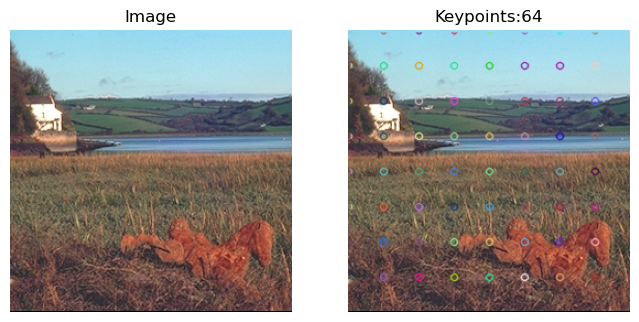

In [11]:
# let's sample an image
sample = train_images_filenames[18]
img=cv2.imread(sample)
#plt.imshow(img)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# To compute dense SIFT
SIFTdetector = cv2.xfeatures2d.SIFT_create()
dense_kp = create_dense_kp(gray.shape, step_div_size=8, num_sizes=1)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)
draw_keypoints(img, kps=dense_kp)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [12]:
def keypoint_descriptor(detector, features=0, kps=None):
    ## method to create a keypoint descriptor with a given number of features
    Train_descriptors = []
    Train_label_per_descriptor = []

    if detector == "sift":
        detector_instance = cv2.xfeatures2d.SIFT_create(nfeatures=features)
    elif detector == "surf":
        detector_instance = cv2.xfeatures2d.SURF_create(features)
    elif detector == "akaze":
        detector_instance = cv2.AKAZE_create(threshold=0.0001)
    else:
        raise NotImplementedError()
    
    for filename,labels in zip(train_images_filenames, train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        if kps is None:
            kpt,des=detector_instance.detectAndCompute(gray,None)
        else:
            kpt,des=detector_instance.compute(gray,kps)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    
    D=np.vstack(Train_descriptors)
    return D, Train_descriptors, detector_instance

In [13]:
def get_dense_kp(image_shape, step_size,scales, distribution="random"):
    # function to get the proper number of keypoints
    if distribution == "random":
        kps = []
        for x in range(0, image_shape[1], step_size):
            for y in range(0, image_shape[0], step_size):
                for scale in scales:
                    scale = scale * random.uniform(1, 3)
                    kp = cv2.KeyPoint(x, y, scale)
                    kps.append(kp)
    else:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image_shape[0], step_size) 
                                    for x in range(0, image_shape[1], step_size)]
    return kps

Now we create the function for computing the optimal step size and scale 

In [22]:
# Default values used for computing the optimal number of features
k=128
N_CLUSTERS = 128
K_FOLDS = 5
step_sizes = [8, 16, 32]
PARAM_GRID = {'C': [1], 'kernel': ['rbf'], 'gamma': ['scale']}
results_test = []
results_train = []

def experiment_diferent_size_and_scale(step_size,scales):
    #k = 128
    kps = get_dense_kp(img_sample_gray.shape,step_size,scales)

    D, Train_descriptors, detector = keypoint_descriptor("sift", 0, kps)

    #draw_keypoints(img_sample, detector, kps)

    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    
    cv = GridSearchCV(svm.SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
    cv.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kps = get_dense_kp(gray.shape , step_size, scales)
        kpt,des=detector.compute(gray, kps)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = cv.score(visual_words_test, test_labels)
    print('Step size: ',step_size,'Scales: ',scales,'Accuracy: ',accuracy*100)
    results_train.append(cv.score(visual_words, train_labels))
    results_test.append(accuracy)
    return accuracy, D,Train_descriptors, detector

In [ ]:
import itertools
step_sizes = [5,15,30]
scale = [1,2,3,4,5]
scales = [[1],[0.8,1],[0.6,0.8,1],[0.4,0.6,0.8,1],[0.2,0.4,0.6,0.8,1]]
all_combinations = list(itertools.product(step_sizes, scale))

In [ ]:
accuracies = []
for values in all_combinations:
    f_scales = multiplied_list = [int(element * values[0]) for element in scales[values[1]-1]]
    accuracy, D,Train_descriptors, detector = experiment_diferent_size_and_scale(values[0],f_scales)
    accuracies.append(accuracy)

Step size:  5 Scales:  [5] Accuracy:  81.78438661710037
Step size:  5 Scales:  [4, 5] Accuracy:  81.5365551425031
Step size:  5 Scales:  [3, 4, 5] Accuracy:  82.5278810408922
Step size:  5 Scales:  [2, 3, 4, 5] Accuracy:  80.29739776951673
Step size:  5 Scales:  [1, 2, 3, 4, 5] Accuracy:  81.41263940520446
Step size:  15 Scales:  [15] Accuracy:  81.41263940520446
Step size:  15 Scales:  [12, 15] Accuracy:  82.5278810408922
Step size:  15 Scales:  [9, 12, 15] Accuracy:  81.90830235439901
Step size:  15 Scales:  [6, 9, 12, 15] Accuracy:  85.25402726146221
Step size:  15 Scales:  [3, 6, 9, 12, 15] Accuracy:  83.39529120198264
Step size:  30 Scales:  [30] Accuracy:  76.33209417596035
Step size:  30 Scales:  [24, 30] Accuracy:  76.82775712515489
Step size:  30 Scales:  [18, 24, 30] Accuracy:  80.545229244114
Step size:  30 Scales:  [12, 18, 24, 30] Accuracy:  81.41263940520446
Step size:  30 Scales:  [6, 12, 18, 24, 30] Accuracy:  82.15613382899627


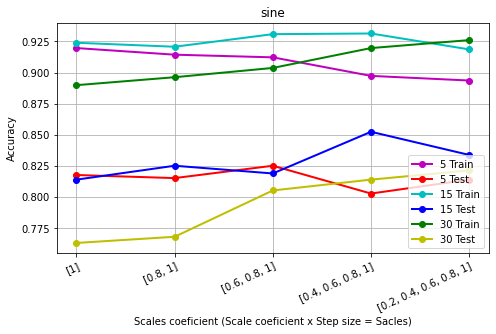

The maximum accuracy is obtained with a value of 0.853 step size of 15 and [0.2, 0.4, 0.6, 0.8, 1] scale


In [ ]:
str_scales = ['[1]', '[0.8, 1]', '[0.6, 0.8, 1]', '[0.4, 0.6, 0.8, 1]', '[0.2, 0.4, 0.6, 0.8, 1]']
str_step_sizes = ['5', '15', '30']

fig = plt.figure()
ax = fig.add_axes([0,0, 1, 0.8]) # main axes
ax.plot(results_train[0:5],'mo-',linewidth=2,label='5 Train')
ax.plot(results_test[0:5],'ro-',linewidth=2,label='5 Test')
ax.plot(results_train[5:10],'co-',linewidth=2,label='15 Train')
ax.plot(results_test[5:10],'bo-',linewidth=2,label='15 Test')
ax.plot(results_train[10:15],'go-',linewidth=2,label='30 Train')
ax.plot(results_test[10:15],'yo-',linewidth=2,label='30 Test')
ax.set_xlabel('Scales coeficient (Scale coeficient x Step size = Sacles)')
ax.set_ylabel('Accuracy')
ax.set_title('sine')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(str_scales)
plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
         rotation_mode="anchor")
ax.legend()
ax.grid(True)
plt.show()

max_position = accuracies.index(max(accuracies))
plt.show()
print('The maximum accuracy is obtained with a value of {} step size of {} and {} scale'.format(np.round(accuracies[max_position],3),all_combinations[max_position][0],scales[all_combinations[max_position][1]]))

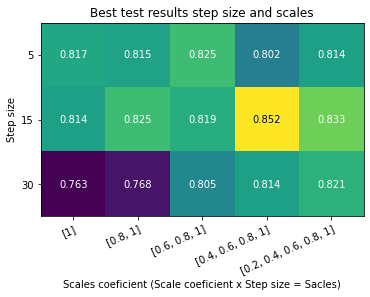

In [ ]:
arr_results_test = np.array(results_test)
mtx_results_test = np.array([[results_test[0:5],
                                results_test[5:10],
                                results_test[10:15]]])

mtx_results_test = np.array([[0.817, 0.815, 0.825, 0.802, 0.814],
                [0.814, 0.825, 0.819, 0.853, 0.833],
                [0.763, 0.768, 0.805, 0.814, 0.821]])
max_accuracy = 85.3
fig, ax = plt.subplots()
im = ax.imshow(mtx_results_test)

ax.set_xticks(np.arange(len(str_scales)))
ax.set_yticks(np.arange(len(str_step_sizes)))
ax.set_xticklabels(str_scales)
ax.set_yticklabels(str_step_sizes)
ax.set_ylabel('Step size')
ax.set_xlabel('Scales coeficient (Scale coeficient x Step size = Sacles)')
plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
         rotation_mode="anchor")
for i in range(len(str_step_sizes)):
    for j in range(len(str_scales)):
        text = ax.text(j, i, mtx_results_test[i, j],
                       ha="center", va="center", color="white")
text = ax.text(3, 1, 0.852, ha="center", va="center", color="black")

ax.set_title("Best test results step size and scales")
fig.tight_layout()
ax.dist = 15
plt.show()

After computing the the optimal step size and scale, we can concude that the best performing combination is step size of 15 with the scale of [6, 9, 12, 15] that give us an accuracy of 85,3%.

---

***Data Normalization***

---

The data normalization is a good practice that in some cases, where the data has huge differences in scales it becomes a must.

We will implement 3 kinds of normalization.
- L2 norm: Normalize the feature vector to 1
$$
x_{\text {norm }}=\frac{x}{\|x\|_{2}} 
$$

$$
\|x\|_{2}=\sqrt{x_{1}^{2}+x_{2}^{2}+x_{3}^{2}+\ldots+x_{m}^{2}}
$$

- Power norm: A featurewise transform to make data more Gaussian-like
$$
x_{\text {norm }}=\frac{x}{\sum_{i=1}(x_{i})} 
$$


- StandardScaler: Normalize the feature vector by removing the mean and dividing by standard deviation
$$
x_{\text {norm }}=\frac{x-\mu}{\sigma} ; \quad \mu: mean, \sigma: std
$$

In [93]:
# feature normalization
def feature_normalization(features, norm='standard'):
    
    if norm == 'l2':
        transform = Normalizer(norm='l2')
        values = transform.fit_transform(features)

    elif norm == 'power':
        transform = PowerTransformer()
        values = transform.fit_transform(features)
        
        
    elif norm == 'standard':
        transform = StandardScaler()
        values = transform.fit_transform(features)
        
    return transform, values

In [16]:
#parametets 
k=256
num_neighbors=10
metric = 'manhattan'
step_size = 15
scales = [6, 9, 12, 15]

kps = get_dense_kp(img_sample_gray.shape , step_size,  scales)

# Create and train the keypoints descriptot
D, Train_descriptors, detector = keypoint_descriptor("sift", 0, kps)

# We now compute a k-means clustering on the descriptor space
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

# And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kps = get_dense_kp(gray.shape , step_size, scales)
    kpt,des=detector.compute(gray, kps)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)


In [26]:
#data_transform, _ = feature_normalization(visual_words, norm='standard')
accuracy = []
normalizations = [None, "l2", "power", "standard"]
for norm in normalizations:
    if norm is not None:
        transform, visual_words_normalized = feature_normalization(visual_words, norm=norm)
        visual_words_test_norm = transform.transform(visual_words_test)
    else:
        visual_words_normalized = visual_words
        visual_words_test_norm = visual_words_test

    #lda = LinearDiscriminantAnalysis(n_components=7)
    #VWlda = lda.fit_transform(visual_words_normalized, train_labels)

    svc = svm.SVC(kernel="rbf", C=1) 
    svc.fit(visual_words_normalized, train_labels)
    score = svc.score(visual_words_test_norm, test_labels)

    accuracy.append(score)

print(accuracy)

[0.8215613382899628, 0.8314745972738538, 0.838909541511772, 0.815365551425031]


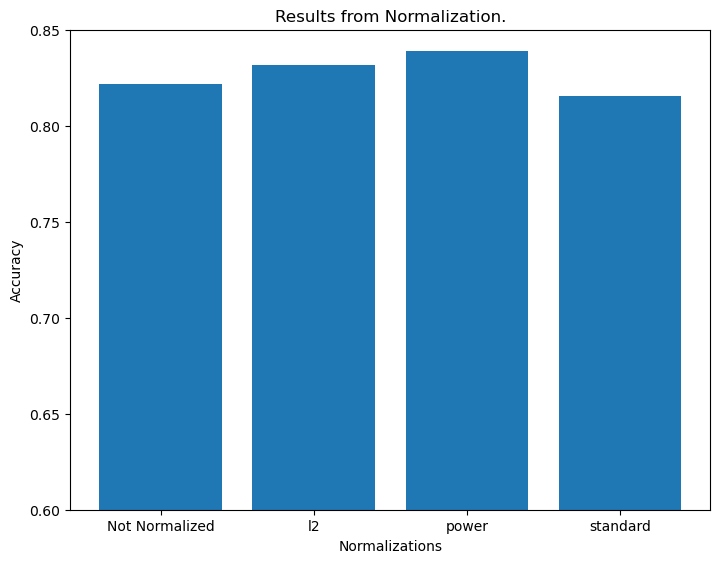

In [27]:
normalizations[0] = "Not Normalized"
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(normalizations,accuracy)
#ax.set_yticks(np.arange(0, 1.0, 0.05))
plt.title('Results from Normalization.')
plt.ylim([0.6, 0.85])
plt.ylabel('Accuracy')
plt.xlabel('Normalizations')

plt.show()


As we can see the obtained result is slightly better for any of the data normalization techniques. However, the difference is really small

---

***SVM Classifier***

---

The first step is to use the standard scalar in order to normalize the data

In [28]:
transform, visual_words_normalized = feature_normalization(visual_words, norm='standard')


Then, we will use the SVM to classify the images. 
Also, we will look for the best parameters of SVM by means of GridSearch.

One of the kernels have to be implemented: the histogram intersection.

$$ K_{int}(A, B)= \sum_{i=1}^{m} \min {(hist1, hist2)}  $$

Here is the proposed implementation:

In [18]:
def hist_intersection(hist1, hist2):
    Kernel = np.empty(shape=(hist1.shape[0], hist2.shape[0]))
    for i in range(hist1.shape[0]):
        Kernel[i] = np.sum(np.minimum(hist1[i], hist2), axis=1)
    return Kernel

Now let's test the SVM classifier with each kernel

In [30]:

parameters = {'kernel':('linear', 'poly', 'rbf', hist_intersection)}
svc = svm.SVC() 
grid = GridSearchCV(svc, parameters, cv=8)
grid.fit(visual_words_normalized, train_labels)

GridSearchCV(cv=8, estimator=SVC(),
             param_grid={'kernel': ('linear', 'poly', 'rbf',
                                    <function hist_intersection at 0x7f401dd5e320>)})

Let's check the results

In [31]:
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_kernel','mean_test_score','std_test_score']]

,param_kernel,mean_test_score,std_test_score
0,linear,0.786822,0.026042
1,poly,0.763976,0.039715
2,rbf,0.819794,0.036812
3,<function hist_intersection at 0x7f401dd5e320>,0.822460,0.031576


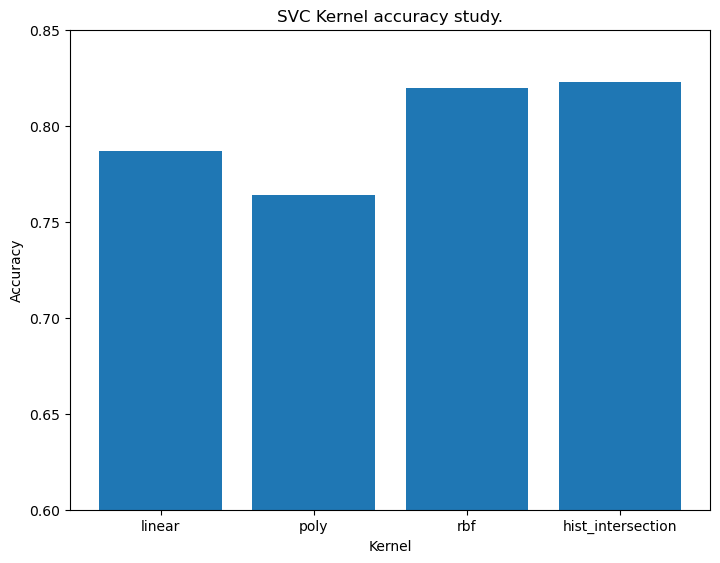

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels_bar = ['linear', 'poly', 'rbf', 'hist_intersection']
ax.bar(labels_bar,svm_kernel_pd['mean_test_score'])
#ax.set_yticks(np.arange(0, 1.0, 0.05))
plt.title('SVC Kernel accuracy study.')
plt.ylim([0.6, 0.85])
plt.ylabel('Accuracy')
plt.xlabel('Kernel')

plt.show()

As we can see the kernels that best performance give us are the RBF and the proposed histogram intersection.

Now, let's test the accuracy variation by studing the regularitzation term. For this purpose we will use a logarithmic scale

In [33]:
parameters = {'C':np.logspace(-5, 7, 20)}
svc = svm.SVC(kernel=hist_intersection) 
grid = GridSearchCV(svc, parameters, cv=8)
grid.fit(visual_words_normalized, train_labels)

GridSearchCV(cv=8,
             estimator=SVC(kernel=<function hist_intersection at 0x7f401dd5e320>),
             param_grid={'C': array([1.00000000e-05, 4.28133240e-05, 1.83298071e-04, 7.84759970e-04,
       3.35981829e-03, 1.43844989e-02, 6.15848211e-02, 2.63665090e-01,
       1.12883789e+00, 4.83293024e+00, 2.06913808e+01, 8.85866790e+01,
       3.79269019e+02, 1.62377674e+03, 6.95192796e+03, 2.97635144e+04,
       1.27427499e+05, 5.45559478e+05, 2.33572147e+06, 1.00000000e+07])})

In [34]:
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_C','mean_test_score','std_test_score']]

,param_C,mean_test_score,std_test_score
0,0.00001,0.155236,0.002054
1,0.000043,0.155236,0.002054
2,0.000183,0.472627,0.028507
3,0.000785,0.777270,0.035990
4,0.00336,0.818187,0.038436
5,0.014384,0.826179,0.033727
6,0.061585,0.822460,0.031576
7,0.263665,0.822460,0.031576
8,1.128838,0.822460,0.031576
9,4.83293,0.822460,0.031576


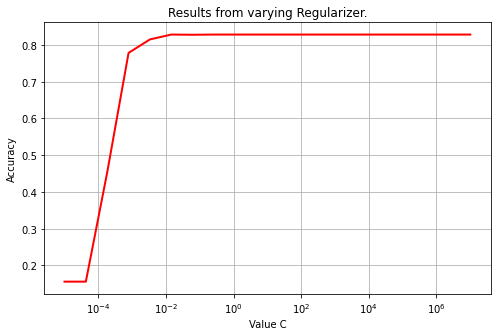

In [22]:
plt.figure(figsize=(8, 5))
plt.title('Results from varying Regularizer.')
plt.xscale('log',base=10)
plt.ylabel('Accuracy')
plt.xlabel('Value C')
plt.grid(True)
plt.plot(svm_kernel_pd['param_C'],svm_kernel_pd['mean_test_score'],'r',linewidth=2,)
plt.show()

As we can see, once we obtain the a C > 0.02, the accuracy is not affected by the increase of C

Finally, we will test the effect of the polynomial grade in the accuracy. Of course, it is only valid for "poly" kernel.

In [23]:
parameters = {'degree':(0,1,3,5,7,9)}
svc = svm.SVC(kernel='poly') 
grid = GridSearchCV(svc, parameters, cv=8)
grid.fit(visual_words_normalized, train_labels)
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_degree','mean_test_score','std_test_score']]

,param_degree,mean_test_score,std_test_score
0,0,0.155236,0.002054
1,1,0.811810,0.033439
2,3,0.760260,0.045166
3,5,0.490187,0.043707
4,7,0.319534,0.025466
5,9,0.237653,0.014065


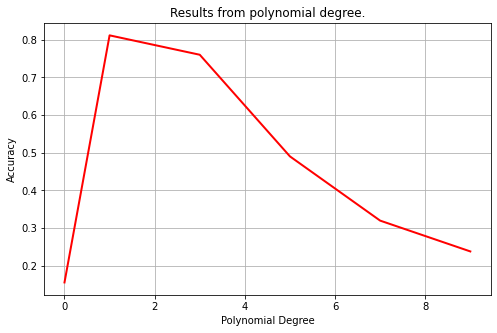

In [24]:
plt.figure(figsize=(8, 5))
plt.title('Results from polynomial degree.')
plt.ylabel('Accuracy')
plt.xlabel('Polynomial Degree')
plt.grid(True)
plt.plot(svm_kernel_pd['param_degree'],svm_kernel_pd['mean_test_score'],'r',linewidth=2,)
plt.show()

As we can see our system can be modeled by a polinomy of degree 1.

---

***Cross-Validation with StratifiedKFold***

---

Stratified K fold cross-validation is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. It provides train/test indices to split data in train/test sets.


In [19]:
NUM_SPLITS = 5
skf = StratifiedKFold(n_splits=NUM_SPLITS)
skf.get_n_splits(visual_words, train_labels)
char_to_int = dict((c, i) for i, c in enumerate(train_labels))
train_labels = np.array([char_to_int[char] for char in train_labels])
print('Training with a total of {}'.format(NUM_SPLITS))
classifiers = []
for i,(train_index, test_index) in enumerate(skf.split(visual_words, train_labels)):
    svc = svm.SVC(kernel=hist_intersection)
    classifiers.append(svc)
    X_train, X_test = visual_words[train_index], visual_words[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    svc.fit(X_train, y_train)
    print('Obtained accuracy of {} with fold {}'.format(svc.score(X_test,y_test),i))

Training with a total of 5
Obtained accuracy of 0.8037135278514589 with fold 0
Obtained accuracy of 0.8297872340425532 with fold 1
Obtained accuracy of 0.8297872340425532 with fold 2
Obtained accuracy of 0.8776595744680851 with fold 3
Obtained accuracy of 0.7925531914893617 with fold 4


As we can see we have reached an accuracy of 87.5 % on the test set with the Cross Validation

Now let's see the confusion matrix from the best model obtained

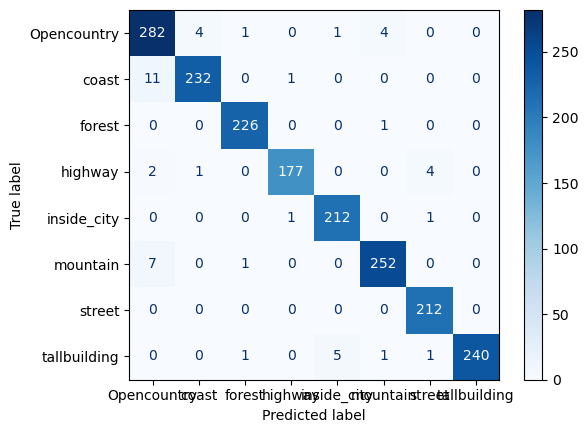

In [37]:
ConfusionMatrixDisplay.from_estimator(
    classifiers[3],
    visual_words,
    train_labels,
    display_labels= np.unique(np.array(test_labels)),
    cmap=plt.cm.Blues,
)
plt.show()

---

***Spatial Pyramids***

---

Since Bag of Visual Words ignores the spatial information of the features whitin an image, we compute the keypoints and descriptors at different pyramidal levels. 
Spatial pyramids work by dividing the image into increasingly sub-regions and computing histograms of the codewords inside each sub-region.

We divide the images in square sub-regions depending on the level we want:

- Level 0: computes descriptors of the whole image.
- Level 1: divides the image in 4 blocks and compute the descriptors for each of them, and finally concatenate them with the whole image descriptor.
- Level 2: divides the image in 16 blocks and compute the descriptors for each of them, and finally concatenate them with the whole image descriptor.
- ...

Let's first create a function to compute the Dense SIFT descriptors from the different sub-regions of the image and then we concatenate them

In [72]:
def spatial_pyramid(img, descriptor= SIFTdetector, level=1, step_size=15, scales= [1]):
    
    #compute Dense SIFT descriptors
    dense_kps = get_dense_kp(img.shape, step_size= step_size, scales=scales)
    _, des = descriptor.compute(img, dense_kps)
    
    # list that contains the descriptors of img at different levels
    pyramid_des = [des]  # pyramid_des[0] -> descriptors of the whole image
                         # pyramid_des[1:4] -> descriptors of the four blocks (of size 1/4 of the image size)
    
    #Divide the image in sub-regions and compute its descriptors
    for l in range(1, level+1):
        level_factor = 2*l
        block_h = int(gray.shape[0]/level_factor)
        block_w = int(gray.shape[1]/level_factor)
        
        dense_kp_block = get_dense_kp([block_h,block_w], step_size=step_size, scales=scales)
            
        for f_h in range(level_factor):
            shift_h = f_h * block_h
            for f_w in range(level_factor):
                shift_w = f_w * block_w
                block = img[shift_h : shift_h+block_h, shift_w : shift_w+block_w]
                _, des = descriptor.compute(block, dense_kp_block)
                pyramid_des.append(des)

    return pyramid_des

In [73]:
#obtain pyramid descriptors for a given image
filename = train_images_filenames[0]
ima = cv2.imread(filename)
gray = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
pyramid_des = spatial_pyramid(gray, level=1)
print("Pyramid descriptor shape: ", len(pyramid_des))

Pyramid descriptor shape:  5


We compute the SIFT pyramid descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [74]:
def train_spatial_pyramid_descriptors(descriptor=SIFTdetector, level=1, step_size=15, scales=[1]):
    
    Train_descriptors = []
    train_pyramid_descriptors = []

    for filename in train_images_filenames:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)       
        pyramid_des = spatial_pyramid(gray, level= level, scales= scales)
        train_pyramid_descriptors.append(pyramid_des)
        Train_descriptors.append(pyramid_des[0])
    
    D = np.vstack(Train_descriptors)    

    return D, train_pyramid_descriptors

In [75]:
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    """
    Compute the pyramid histograms (visual words) of the descriptors of the image
    """
    visual_words = np.zeros(k*len(pyramid_descriptor), dtype= np.float32)

    for d in range(len(pyramid_descriptor)):
        
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k] = np.zeros(k) # If no keypoints are detected, the frequency of the visual words is 0
        else:
            words = codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k] = np.bincount(words, minlength=k)
     
    return visual_words

We now compute the test accuracy taking into account different pyramid levels (level 0, level 1, and level 2)

In [76]:
# Default values used for computing the optimal number of piramid levels
k=256
num_neighbors=10
step_size = 15
scales = [6, 9, 12, 15]

# we will try different piramid levels to get the number of level with the best accuracy 
nLevelsList = [0, 1, 2]
accuracyNLevels = np.zeros(len(nLevelsList))

for pos in range(len(nLevelsList)):
    
    nLevels = nLevelsList[pos]
    #print(nLevels)

    # Create and train the keypoints descriptor
    D, train_pyramid_descriptors = train_spatial_pyramid_descriptors(level=nLevels, scales=scales)
    
    # We now compute a k-means clustering on the descriptor space
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    # And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.
    visual_words_pyramid = np.zeros((len(train_pyramid_descriptors), k*len(train_pyramid_descriptors[0])), dtype=np.float32)
    for i in range(len(train_pyramid_descriptors)):
        visual_words_pyramid[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook, k)

    #Normalize train visual words
    _, vw_normalized = feature_normalization(visual_words_pyramid, 'standard')

    # We build a SVC classifier and train it with the train descriptors
    svc = svm.SVC(kernel=hist_intersection)
    svc.fit(vw_normalized, train_labels)

    #We end up computing the test descriptors and compute the accuracy of the model
    visual_words_test = np.zeros((len(test_images_filenames),visual_words_pyramid.shape[1]), dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        test_pyramid_des = spatial_pyramid(gray, level=nLevels, scales=scales)
        visual_words_test[i,:]= spatial_pyramid_histograms(test_pyramid_des, codebook, k)
    
    #Normalize test visual words
    _, vw_test_normalized = feature_normalization(visual_words_test, 'standard')

    accuracyNLevels[nLevels]  = 100*svc.score(vw_test_normalized, test_labels)
    print(accuracyNLevels)

[82.89962825  0.          0.        ]
[82.89962825 85.87360595  0.        ]
[82.89962825 85.87360595 84.26270136]


In [82]:
#Show the results
pyramid_level_acc = pd.DataFrame(accuracyNLevels, index =['Level 0', 'Level 1', 'Level 2'], columns= ['Accuracy (%)'])
pyramid_level_acc.round(2)

,Accuracy (%)
Level 0,82.90
Level 1,85.87
Level 2,84.26


---

***Fisher Vectors***

---

In order to try to improve the performance of our model we are going to use Fisher vectors instead of BoVW. With fisher vectors we're not only using the mean of the local descriptors (like in BoVW), but we're also including higher order statistics: the covariance. This way, we're obtaining information of how far is each feature from its closest vocabulary word, and also to the other vocabulary words.

So now we are going to use the fisher vectors approach to study its performance in our problem.

For this purpose, we will use the implementation of jonasrothfuss on github: https://github.com/jonasrothfuss/fishervector

First, let's intall it

In [ ]:
%pip install fishervector

We load the precomputed dense SIFT descriptors, computed with step_div_size=15 and scales= [6, 9, 12, 15], which gave us the best results.

In [ ]:
import pickle
def load_pickle(path):
    """
    Retrieve pickle file containing ground truths of query images
    """
    with open(path, 'rb') as f:
        query_gt = pickle.load(f)
    return query_gt

Train_descriptors_dense = load_pickle('train_sift_descriptors_dense.pkl')
Test_descriptors_dense = load_pickle('test_sift_descriptors_dense.pkl')

In [15]:
print(Train_descriptors_dense.shape)
print(Test_descriptors_dense.shape)

(1881, 1296, 128)
(807, 1296, 128)


In [16]:
from fishervector import FisherVectorGMM

We will use only 4 kernels, because is the maximum that fit in our PC memory

In [17]:
#Train and fit the GMM (Gaussian mixture model) using the BIC(Bayesian Information Criterion) to determine the number of GMM components (clusters) automatically
fv_gmm = FisherVectorGMM(n_kernels=4).fit(Train_descriptors_dense)
#fv_gmm = FisherVectorGMM().fit_by_bic(Train_descriptors_dense, choices_n_kernels=[1, 2, 4, 8, 16, 32, 64, 128]) 

fitted GMM with 4 kernels


In [18]:
#Computing fisher vectors
#image_data_test = Train_descriptors_dense[:20]  # use a fraction of the data to compute the fisher vectors
train_fv = fv_gmm.predict(Train_descriptors_dense)
test_fv = fv_gmm.predict(Test_descriptors_dense)

In [2]:
# Build a SVM Classifier
classifier = svm.SVC(kernel=hist_intersection)
classifier.fit(train_fv, train_labels)
accuracy = 100*classifier.score(test_fv, test_labels)
print("Fisher Vectore GMM accuracy: " + str(accuracy) )

Fisher Vectore GMM accuracy: 80.05


Finally, we plot the best model results, with the ROC curve

In [36]:
# to print the ROC curve is necessary to binarize the data

y_train = LabelBinarizer().fit_transform(train_labels)
y_test = LabelBinarizer().fit_transform(test_labels)
n_classes = y_train.shape[1]


In [37]:
# The classifier mus be defined as One vs rest approach
clf = OneVsRestClassifier(svm.SVC(kernel=hist_intersection))
clf.fit(visual_words, y_train)
y_score = clf.decision_function(visual_words_test)

# Compute ROC curve and ROC area for each class
false_posr = dict()
true_posr = dict()
roc_auc = dict()
for i in range(n_classes):
    false_posr[i], true_posr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(false_posr[i], true_posr[i])
all_falsepr = np.unique(np.concatenate([false_posr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_falsepr)
for i in range(n_classes):
    mean_tpr += np.interp(all_falsepr, false_posr[i], true_posr[i])

mean_tpr /= n_classes

false_posr["macro"] = all_falsepr
true_posr["macro"] = mean_tpr
roc_auc["macro"] = auc(false_posr["macro"], true_posr["macro"])

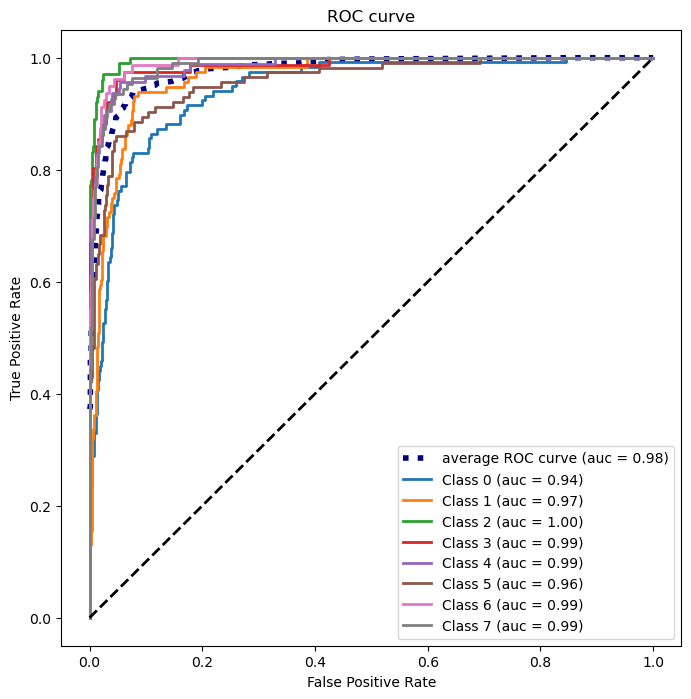

In [35]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(false_posr["macro"], true_posr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


for i in range(n_classes):
    plt.plot(false_posr[i], true_posr[i], lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

---

***Final conclusions***

---

In this week we have studied the importance of scale when extracting keypoints.
As it can be seen in the notebook, the scale is not extremely determinant with respect to the accuracy obtained. 

Accuracy near 83% is obtained throughout all the step sizes, with scales from 5 to 30.

A similar conclusion can be obtained when analyzing the performance of the different normalization methods.
Power normalization dominates over the other in accuracy however, the difference is not significant.

This week’s classifier was SVM instead of k-mean clustering.We have studied the different kernels: linear, 
poly and RBF and histogram intersection.The best performance is obtained with RBF and histogram intersection. 
Even though we have tunned the regularization term and the polynomial degree with GridSearch, polynomial kernels did not perform similar to the others kernel modes.

This week’s new cross-validation method was Stratified Kfold. As we can see with a value of 5, we can improve the accuracy to a 85.7%.
The downside of that is that we need to train independently for 5 datasets, therefore increasing the training time by 5.

For the pyramid section the best accuracy is obtained with 1 level of pyramids, which means with that the images are splited in four smaller images. It let us a performace of 85.87 % of accuracy

Fisher vectors allows training more discriminative classifiers with a lower vocabulary size. Even with n_kernels=4, we get quite good results in just a few seconds. 
The higher the number of clusters, the higher the accuracy as well, as GMM is able to model our data with more precision. However, the computational time also increases.

Although we can not use higher order kernels because of PC memory, encoding our feature vectors using second order information (covariances along with  means) should improve classification performance, 
as it provides good results with only 4 clusters.